<a href="https://colab.research.google.com/github/tfrizza/DALL-E-tf/blob/main/tfFlowers_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
%pip install -q tensorflow_addons

     |████████████████████████████████| 706kB 5.4MB/s 


In [1]:
!git clone https://github.com/tfrizza/DALL-E-tf.git

Cloning into 'DALL-E-tf'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 60 (delta 31), reused 29 (delta 13), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [1]:
%cd DALL-E-tf

/content/DALL-E-tf


In [2]:
import tensorflow as tf
from tensorflow.keras import Model, mixed_precision
from tensorflow.keras.losses import Loss, MeanSquaredError, MeanAbsoluteError, MSE, MAE
from tensorflow.keras.optimizers import Adam

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl

import tensorflow_datasets as tfds
from tensorflow_addons.optimizers import LAMB, AdamW

from dall_e_tf.encoder import dvae_encoder
from dall_e_tf.decoder import dvae_decoder
from dall_e_tf.vae import dVAE
from dall_e_tf.losses import LatentLoss
from dall_e_tf.utils import plot_reconstructions

import numpy as np

mixed_precision.set_global_policy('float32')
AUTOTUNE = tf.data.AUTOTUNE

In [27]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)
NUM_DEVICES = strategy.num_replicas_in_sync
print("REPLICAS: ", NUM_DEVICES)

Running on TPU  ['10.31.146.146:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.31.146.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.146.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [28]:
def crop(image):
    y_nonzero, x_nonzero, _ = tf.experimental.numpy.nonzero(image)
    return image[tf.reduce_min(y_nonzero):tf.reduce_max(y_nonzero), tf.reduce_min(x_nonzero):tf.reduce_max(x_nonzero)]

def preprocess(data, h=128, w=128):
    img = crop(data['image'])
    img = tf.image.resize(img, size=(h,w), antialias=False)
    img /= 255
    return img, img

train_dataset = tfds.load('tf_flowers', 
                            split='train', 
                            shuffle_files=True,
                            try_gcs=True
                          )
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)\
                             .batch(32 * NUM_DEVICES)\
                             .prefetch(buffer_size=AUTOTUNE)
train_dataset

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>

In [29]:
class LatentLoss(Loss):

    def call(self, dummy_ground_truth, outputs):
        # del dummy_ground_truth
        z_e, z_q = tf.split(outputs, 2, axis=-1)
        vq_loss = tf.reduce_mean(tf.square(tf.stop_gradient(z_e) - z_q))
        commit_loss = tf.reduce_mean(tf.square(z_e - tf.stop_gradient(z_q)))
        return vq_loss + 1.0 * commit_loss

In [30]:
vocab_size = 4096
n_hid = 128

def dVAE(enc, dec, temperature=1/16):
    z_e = enc.output # encoder logits

    z_q = tfpl.DistributionLambda(
        lambda logits: tfd.RelaxedOneHotCategorical(temperature, logits) # Gumbel-softmax
    )(z_e)

    z_hard = tf.math.argmax(z_e, axis=-1) # non-differentiable
    z_hard = tf.one_hot(z_hard, enc.output.shape[-1], dtype=z_q.dtype)

    z = z_q + tf.stop_gradient(z_hard - z_q) # straight-through Gumbel-softmax
    x_rec = dec(z)
    latents = tf.stack([z_hard, z_q], -1, name='latent')
    return Model(enc.input, [x_rec, latents])

with strategy.scope():
    enc = dvae_encoder(group_count=4, n_hid=n_hid, n_blk_per_group=2, input_channels=3, vocab_size=vocab_size)
    dec = dvae_decoder(group_count=4, n_init=n_hid//2, n_hid=n_hid, n_blk_per_group=2, output_channels=3, vocab_size=vocab_size)

    vae = dVAE(enc, dec, 1.0)
    vae.compile(loss=['mse', None], loss_weights=[1, 0], 
            optimizer=Adam(1e-3),
            steps_per_execution=5)

vae.summary(line_length=200)

Model: "model_17"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_11 (InputLayer)                                             [(None, None, None, 3)]                     0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
conv2d_375 (Conv2D)                                               (None, None, None, 128)                     18944                   input_11[0][0]                              

In [ ]:
vae.fit(train_dataset,
        # validation_data=(x_test, x_test),
        # steps_per_epoch=10,
        epochs=1000,
        # batch_size=32,
        # shuffle=True
        )

Epoch 1/1000
15/15 [==============================] - 7s 484ms/step - loss: 0.0222 - model_16_loss: 0.0222
Epoch 2/1000
15/15 [==============================] - 7s 484ms/step - loss: 0.0219 - model_16_loss: 0.0219
Epoch 3/1000
15/15 [==============================] - 7s 484ms/step - loss: 0.0226 - model_16_loss: 0.0226
Epoch 4/1000
15/15 [==============================] - 7s 481ms/step - loss: 0.0217 - model_16_loss: 0.0217
Epoch 5/1000
15/15 [==============================] - 7s 479ms/step - loss: 0.0212 - model_16_loss: 0.0212
Epoch 6/1000
15/15 [==============================] - 7s 482ms/step - loss: 0.0222 - model_16_loss: 0.0222
Epoch 7/1000
15/15 [==============================] - 7s 480ms/step - loss: 0.0218 - model_16_loss: 0.0218
Epoch 8/1000
15/15 [==============================] - 7s 480ms/step - loss: 0.0211 - model_16_loss: 0.0211
Epoch 9/1000
15/15 [==============================] - 7s 480ms/step - loss: 0.0218 - model_16_loss: 0.0218
Epoch 10/1000
15/15 [================

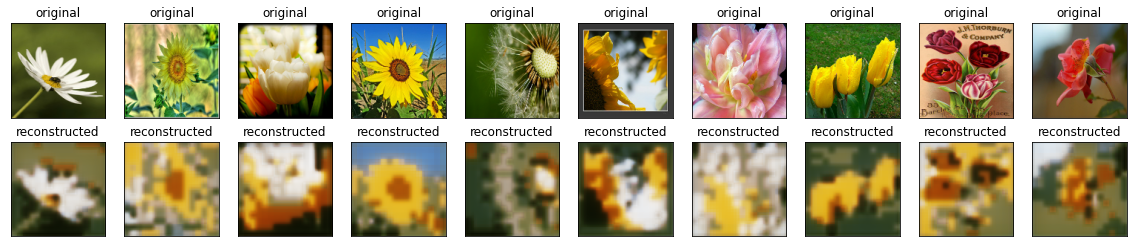

In [32]:
train_batch = next(iter(train_dataset))[0]
plot_reconstructions(vae(train_batch[:10])[0], train_batch[:10])